# Assignment 1

## Part 2, Question A

### Markov Decision Processes and dynamic programming

Xiangyi Zhang (260906083), Rahul Patel (260904634), Polytechnique Montreal

We are given a stochastic Gridworld of size nxn with terminal states in the upper right and upper left corner, with a reward of +10 and +1 respectively. Rewards in all other states are zero. Whenever we take an action A from state S in the Gridworld, we move to the desired next state S' with a probability p and a random state with a probability 1-p. The goal is to find an optimal way to behave in this Gridworld such that we have accumulated maximum rewards when we reach any of the terminal states. Behave, here means the action which an external agent should take, when it is in some particular state of Gridworld. To formalize the notion of behaviour in the context of Gridworld, we introduce one more concept called the state value function. We can query this function to get a numerical estimate of how good it is to be in queried state. Thus, when we have value estimate for all the states of Gridworld, we define the optimal behvior in a state as the action which takes the agent to state with better value. For finding the value of state, we use Dynamic Programming as an iterative solution finding technique to find approximate solution of the state values.

This script demonstrates the use of Dynamic Programming to find an approximation of the true value function. We use this value functions to extract a policy for behaving optimally in the Gridworld.

In [61]:
# Imports
import copy
import itertools
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.table import Table

In [20]:
class Gridworld:
    """
    A class used to represent the Gridworld

    ...
    Attributes
    ----------
    size : int
        The size of Gridworld (size x size)
    action_prob : int
        Probability of moving to desired next state by taking some action in the
        current state
    mapping : 2d array
        Maps the 2d representation of state to a one dimensional representation
        of states. The state [i][j] will be mapped to mapping[i][j]
    rewards : 1d array
        Store the rewards obtained by entering in a state
    num_actions : int
        Total number of actions allowed from any state
    move : list
        Stores moves indexed by actions
    prob_san : 3d array
        Store the transition probabilities P(S' | S, a)

    Methods
    -------
    _generate_valid_next_state(current_state_idx, action, step)
        Generates valid next states, when an agent performs some action in a
        state by preventing it from getting outside the grid

    _generate_next_state_probs()
        Finds the distribution over possible next states given the current state
        and action taken i.e. P(S' | S, a)
    """

    def __init__(self, size, action_prob):
        """
        Parameters
        ----------
        size : int
            The size of the Gridworld
        action_prob : int
            Probability of moving to desired next state by taking some action in the
            current state
        """
        self.size = size
        self.action_prob = action_prob
        self.mapping = np.arange(size ** 2).reshape(size, size)
        self.rewards = np.zeros(size ** 2)
        np.put(self.rewards, [0, size-1], [1.0, 10.0])

        self.num_actions = 4
        # O : Left
        # 1 : Right
        # 2 : Up
        # 3 : Down
        self.move = [np.array([0, -1]),
                     np.array([0, 1]),
                     np.array([-1, 0]),
                     np.array([1, 0])]

        # Initialize P(S' | S, a) with zeros
        self.prob_san = np.zeros(
            (self.size ** 2, self.num_actions, self.size ** 2))
        self._generate_next_state_probs()

    # Make a valid transition to the next state
    def _generate_valid_next_state(self, current_state_idx, action, step):
        """
        Generates valid next states, when an agent performs some action in a
        state by preventing it from getting outside the grid

        Parameters
        ----------
            current_state_idx : int
                The id of the current state
            action : int
                The id of the action taken
            step : 1d array
                The transition to perform from the current state

        Returns
        -------
            The next valid state. Keeps the agent in the current state if the
            agent's action might him out of the Gridworld
        """
        current_state = np.argwhere(self.mapping == current_state_idx)[0]
        next_state = np.asarray(current_state) + step
        # Left
        if action == 0 and next_state[1] < 0:
            next_state = current_state
        # Right
        elif action == 1 and next_state[1] > self.size-1:
            next_state = current_state
        # Up
        elif action == 2 and next_state[0] < 0:
            next_state = current_state
        # Down
        elif action == 3 and next_state[0] > self.size-1:
            next_state = current_state

        return self.mapping[next_state[0]][next_state[1]]

    # Calculate P(S' | S, a)
    def _generate_next_state_probs(self):
        """Finds the distribution over possible next states given the current state
        and action taken i.e. P(S' | S, a)
        """
        # print("Generating P(S' | S, a)")
        for s_idx in range(self.size**2):
            for a_idx in range(self.num_actions):
                # For a given action get all the possible next states and calculate their
                # probabilities
                for move_idx, move_step in enumerate(self.move):
                    ns_idx = self._generate_valid_next_state(
                        s_idx, move_idx, move_step)
                    # Environment moves the agent in the desired direction with probability p
                    # and a random next state state with probability 1-p
                    # TODO: Confirm with TA

                    # if a_idx == move_idx:
                    #     self.prob_san[s_idx][a_idx][ns_idx] += self.action_prob
                    # else:
                    #     self.prob_san[s_idx][a_idx][ns_idx] += (
                    #         1-self.action_prob)/(len(self.move)-1)

                    self.prob_san[s_idx][a_idx][ns_idx] += (1 -
                                                            self.action_prob)/len(self.move)
                    if a_idx == move_idx:
                        self.prob_san[s_idx][a_idx][ns_idx] += self.action_prob

In [21]:
class Agent:
    """
    Agent class which interact with the Gridworld and learns an optimal way
    to behave in it

    Attributes
    ----------
    gamma : int
        Discount factor used to weight the future rewards
    delta : int
        Tolerance used at check termination
    policy : dict(list)
        Store the best action for all states
    state_value : 1d array
        Store state value estimates of all states
    state_mask : 1d array
        Binary array, to set values of terminal state to zero
    prob_sn_pi : 2d array
        Store distribution of over possible next states given the current state,
        following policy pi -- P_pi(S' | S)
    prob_reward_pi : 1d array
        Store expected reward obtained in state S following policy pi -- r_pi(S)

    Methods
    -------
    _generate_random_policy(grid)
        Generate a random policy

    _generate_transition_pi(grid)
        Generate a distribution over possible next state from the current state
        under policy pi

    _generate_reward_pi(grid)
        Generate expected rewards obtained using the current policy pi

    _do_policy_evaluation(grid, eval_steps)
        Find the state values under the current policy

    do_policy_iteration(grid)
        Iteratively find the optimal policy by performing policy evaluation
        and policy improvement

    do_value_iteration(grid)
        Iteratively find the optimal policy by performing value iteration

    do_modified_policy_iteration(grid, eval_steps)
        Iteratively find the optimal policy by performing policy evaluation
        for eval_steps
    """

    def __init__(self, grid, delta, gamma):
        """
        Parameters
        ----------
        grid : object <Gridworld>
        delta : int
            Tolerance used at check termination
        gamma : int
            Discount factor used to weight the future rewards
        """
        self.gamma = gamma
        self.delta = delta
        self.policy = defaultdict(list)
        # Initialize the V_0(S) = 0, for all S
        self.true_state_value = np.zeros(grid.size ** 2)
        self.state_value = np.zeros(grid.size ** 2)
        self.state_mask = np.ones(grid.size ** 2)
        np.put(self.state_mask, [0, grid.size-1], [0, 0])
        # P_pi(S' | S)
        self.prob_sn_pi = np.zeros((grid.size**2, grid.size**2))
        # r_pi(S)
        self.reward_pi = np.zeros(grid.size**2)

    # Generates random policy
    def _generate_random_policy(self, grid):
        """Generate a random policy and set the attribute self.policy

        Parameters
        ----------
            grid : object <Gridworld>
        """
        for state in range(grid.size ** 2):
            self.policy[state] = np.eye(grid.num_actions)[
                np.random.choice(grid.num_actions)]

    # Fixed random policy
    # def _generate_random_policy(self, grid):
    #     for state in range(grid.size ** 2):
    #         self.policy[state] = np.eye(grid.num_actions)[1]

    # Generate P_pi(S' | S)
    def _generate_transition_pi(self, grid):
        """Generate a distribution over possible next state from the current state
        under policy pi and set the attribute self.prob_sn

        Parameters
        ----------
            grid : object <Gridworld>
        """
        # print("Generating transition P_pi(S' | S)")
        for s_idx in range(grid.size ** 2):
            temp_prob_sn = np.zeros(grid.size ** 2)
            action_probs = self.policy[s_idx]
            for a_idx, a_val in enumerate(action_probs):
                temp_prob_sn += np.array(a_val * grid.prob_san[s_idx][a_idx])
            self.prob_sn_pi[s_idx] = temp_prob_sn

    # Generate r_pi(S)
    def _generate_reward_pi(self, grid):
        """Generate expected rewards obtained using the current policy pi and set
        the attribute self.reward_pi

        Parameters
        ----------
            grid : object <Gridworld>
        """
        # print("Generating r_pi(S)")
        for s_idx in range(grid.size ** 2):
            temp_reward_pi = 0
            action_probs = self.policy[s_idx]
            for a_idx, a_val in enumerate(action_probs):
                temp_reward_pi += a_val * \
                    np.dot(grid.prob_san[s_idx][a_idx], grid.rewards)
            self.reward_pi[s_idx] = temp_reward_pi

    def _do_policy_evaluation(self, grid, eval_steps=-1):
        """Find the state values under the current policy and set the attribute
        self.state_value

        Parameters
        ----------
            grid : object <Gridworld>

            eval_steps : int
                Number of itertions to perform policy evaluation
        """
        counter = itertools.count()
        should_stop = False
        while True:
            # Update state values
            updated_state_value = self.reward_pi + self.gamma * \
                np.matmul(self.prob_sn_pi, self.state_value)
            # Apply mask on terminal states
            updated_state_value = np.multiply(
                updated_state_value, self.state_mask)
            # Check stopping criterion
            max_diff = max(np.abs(updated_state_value - self.state_value))
            loop_count = next(counter)
            if max_diff < self.delta:
                should_stop = True
            if loop_count == eval_steps-1:                
                should_stop = True
            # Update the state values
            self.state_value = copy.deepcopy(updated_state_value)
            # Terminate if necessary
            if should_stop:
                return int(loop_count) + 1

    def _do_exact_policy_evaluation(self, grid):
        """Solve linear system to exactly evaluate the state values

        Parameters
        ----------
        grid : object <Gridworld>
        """
        terminal_states = [0, grid.size-1]
        r_pi = copy.deepcopy(self.reward_pi)
        P_pi = copy.deepcopy(self.prob_sn_pi)

        for ts in terminal_states:
            r_pi[ts] = 0
            P_pi[ts] = np.eye(grid.size ** 2)[ts]

        A = np.linalg.inv(np.eye(grid.size ** 2) -
                          (self.gamma * P_pi))
        b = r_pi.reshape(-1, 1)

        self.true_state_value = np.matmul(A, b)        

    def _extract_true_value(self, size):
        """Extract the true value of bottom left and bottom right states        

        Returns
        -------
        Tuple of bottom left and bottom right true state value
        """
        bottom_left_idx = size * (size-1)
        bottom_right_idx = (size * (size-1)) + (size-1)
        bottom_left = copy.deepcopy(self.true_state_value[bottom_left_idx])
        bottom_right = copy.deepcopy(self.true_state_value[bottom_right_idx])

        return (bottom_left, bottom_right)

    def do_policy_iteration(self, grid):
        """Iteratively find the optimal policy by performing policy evaluation
        and policy improvement

        Parameters
        ----------
            grid : object <Gridworld>

        Returns
        -------
            state_value, policy
        """
        counter = itertools.count()
        # Start with a deterministic random policy
        self._generate_random_policy(grid)
        self.state_value = np.zeros(self.state_value.shape)
        evaluation_iterations = []
        true_value = []
        while True:
            # print(next(counter))
            # P_pi(S' | S)
            self._generate_transition_pi(grid)
            # r_pi(S)
            self._generate_reward_pi(grid)
            # Calculate value function and store the number of steps taken to evaluate it
            evaluation_iterations.append(self._do_policy_evaluation(grid))
            self._do_exact_policy_evaluation(grid)
            true_value.append(self._extract_true_value(grid.size))
            # print(np.around(self.true_state_value.reshape(grid.size, grid.size), 6))
            # Policy Improvement
            is_stable = True
            # changed_states = []
            self.state_value = np.around(self.state_value, 8)
            for s_idx, action_probs in self.policy.items():
                # Select the best action as per current policy
                old_action_idx = np.argmax(action_probs)
                # Find the maximizing action
                q_values = []
                for a_idx, _ in enumerate(grid.move):
                    q_values.append(np.dot(grid.prob_san[s_idx][a_idx],
                                           grid.rewards + self.gamma * self.state_value))
                # q_values = np.around(q_values, 8)
                q_max_idx = np.argmax(q_values)
                # Update policy
                self.policy[s_idx] = np.eye(grid.num_actions)[q_max_idx]
                # Check if the action is greedy or not
                if old_action_idx != q_max_idx:
                    # changed_states.append(np.argwhere(grid.mapping == s_idx))
                    is_stable = False
            # print(changed_states)
            # visualize_policy(self.policy, grid.size)
            if is_stable:
                break

        print("Evaluations/Iteration (PI) {} len {}".format(evaluation_iterations,
                                                            len(evaluation_iterations)))
        #print(np.around(self.true_state_value, 8).reshape(grid.size, grid.size))
        return self.state_value.reshape((grid.size, grid.size)), self.policy, true_value

    def do_modified_policy_iteration(self, grid, eval_steps=5):
        """Iteratively find the optimal policy by performing policy evaluation
        and policy improvement

        Parameters
        ----------
            grid : object <Gridworld>

        Returns
        -------
            state_value, policy
        """
        self._generate_random_policy(grid)
        target_state_value = np.zeros(self.state_value.shape)
        evaluation_iterations = []
        true_value = []
        while True:
            # P_pi(S' | S)
            self._generate_transition_pi(grid)
            # r_pi(S)
            self._generate_reward_pi(grid)
            # Evaluate the policy for k steps
            evaluation_iterations.append(
                self._do_policy_evaluation(grid, eval_steps))

            self._do_exact_policy_evaluation(grid)
            true_value.append(self._extract_true_value(grid.size))
            for s_idx, action_probs in self.policy.items():
                if s_idx in [0, grid.size - 1]:
                    continue
                q_values = []
                for a_idx, _ in enumerate(grid.move):
                    q_values.append(np.dot(grid.prob_san[s_idx][a_idx],
                                           grid.rewards + self.gamma * self.state_value))

                q_max_idx = np.argmax(q_values)
                # Update policy. However, we do not check the stability of the policy
                # as an evaluation criterion.
                self.policy[s_idx] = np.eye(grid.num_actions)[q_max_idx]
                target_state_value[s_idx] = q_values[q_max_idx]

            # max (|| V_n - V_n-1 ||) < delta
            # visualize_policy(self.policy, grid.size)
            if max(np.abs(self.state_value - target_state_value)) < self.delta:
                break
        
        
        print("Evaluations/Iteration (MPI, k={}) {} len {}".format(eval_steps,
                                                                   evaluation_iterations, len(evaluation_iterations)))
        #print(np.around(self.true_state_value, 8).reshape(grid.size, grid.size))
        return self.state_value.reshape((grid.size, grid.size)), self.policy, true_value

    def do_value_iteration(self, grid):
        """Iteratively find the optimal policy by performing value iteration

        Parameters
        ----------
            grid : object <Gridworld>

        Returns
        -------
            state_value, policy
        """
        terminal_states = [0, grid.size-1]
        self.state_value = np.zeros(self.state_value.shape)
        counter = itertools.count()
        true_value = []
        while True:
            # visualize_policy(self.policy, grid.size)
            old_state_value = self.state_value.copy()
            # Sweep through state-space and update state-value using Bellman optimality
            # equation
            for s_idx, s_val in enumerate(self.state_value):
                q_values = []
                for a_idx, a_step in enumerate(grid.move):
                    q_values.append(np.dot(grid.prob_san[s_idx][a_idx],
                                           grid.rewards + self.gamma * old_state_value))
                q_max_idx = np.argmax(q_values)
                self.policy[s_idx] = np.eye(grid.num_actions)[q_max_idx]
                self.state_value[s_idx] = q_values[q_max_idx] \
                    if s_idx not in terminal_states else 0.0

            self._generate_reward_pi(grid)
            self._generate_transition_pi(grid)
            self._do_exact_policy_evaluation(grid)
            true_value.append(self._extract_true_value(grid.size))

            loop_count = next(counter)
            # Check stopping criterion
            if max(np.abs(old_state_value - self.state_value)) < self.delta:
                break
        
        print("Value iterations {}".format(int(loop_count)+1))
        #print(np.around(self.true_state_value, 8).reshape(grid.size, grid.size))
        return self.state_value.reshape((grid.size, grid.size)), self.policy, true_value

In [55]:
def visualize_policy(policy, size, fp=None):
    """
    Visualize policy

    Parameters
    ----------
        policy : dict(list)
            Policy to be visualized
        size : int
            Size of the GridWorld
    """
    symbol = {0: '\u2190', 1: '\u2192', 2: '\u2191', 3: '\u2193', 4: '\u25A0'}

    size = int(len(policy)/size)

    for i in range(size):        
        col = ""
        for j in range(size):            
            action = np.argwhere(policy[i*size + j] == 1)[0][0]
            col += " " + symbol[action] + " "
        col += "\n"
        if fp == None:
            print(col)
        else:
            fp.write(col)

In [24]:
# Statistics
stats_bl = defaultdict(list)
stats_br = defaultdict(list)
stats_policy = {}
stats_value = {}

In [25]:
# Experiments for grid of size 50 and action prob 0.7
grid_50 = Gridworld(size=50, action_prob=0.7)
agent = Agent(grid=grid_50, delta=1e-4, gamma=0.9)
print("######################### Size 50, Prob 0.7 #########################")
############### POLICY ITERATION ################
state_value, policy, true_value = agent.do_policy_iteration(grid=grid_50)
key = "50_0.7_PI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_50.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {}".format(np.abs(approx_bl - true_bl)[0]))
    
############### MODIFIED POLICY ITERATION ################
state_value, policy, true_value = agent.do_modified_policy_iteration(
    grid_50, eval_steps=10)
key = "50_0.7_MPI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_50.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {}".format(np.abs(approx_bl - true_bl)[0]))

############### VALUE ITERATION ################
state_value, policy, true_value = agent.do_value_iteration(grid=grid_50)
key = "50_0.7_VI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_50.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {}".format(np.abs(approx_bl - true_bl)[0]))
# Experiments for grid of size 50 and action prob 0.9
grid_5 = Gridworld(size=5, action_prob=0.9)
agent = Agent(grid=grid_5, delta=1e-4, gamma=0.9)

######################### Size 50, Prob 0.7 #########################
Evaluations/Iteration (PI) [63, 67, 46, 27, 15, 11, 8, 7, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] len 79
Absolute difference between the true and approx. value of bottom left state 3.08574892883811e-09
Evaluations/Iteration (MPI, k=10) [10, 10, 10, 10, 10, 10, 10, 10, 7] len 9
Absolute difference between the true and approx. value of bottom left state 3.630906822175029e-05
Value iterations 86
Absolute difference between the true and approx. value of bottom left state 5.129073342008883e-06


In [26]:
# Experiments for grid of size 50 and action prob 0.9
grid_50 = Gridworld(size=50, action_prob=0.9)
agent = Agent(grid=grid_50, delta=1e-4, gamma=0.9)
print("######################### Size 50, Prob 0.9 #########################")
############### POLICY ITERATION ################
state_value, policy, true_value = agent.do_policy_iteration(grid=grid_50)
key = "50_0.9_PI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_50.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

############### MODIFIED POLICY ITERATION ################
state_value, policy, true_value = agent.do_modified_policy_iteration(
    grid_50, eval_steps=10)
key = "50_0.9_MPI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_50.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

############### VALUE ITERATION ################
state_value, policy, true_value = agent.do_value_iteration(grid=grid_50)
key = "50_0.9_VI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_50.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

######################### Size 50, Prob 0.9 #########################
Evaluations/Iteration (PI) [62, 68, 40, 38, 41, 21, 18, 15, 14, 11, 10, 10, 7, 7, 9, 8, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] len 42
Absolute difference between the true and approx. value of bottom left state 0.0 

Evaluations/Iteration (MPI, k=10) [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 3, 2] len 12
Absolute difference between the true and approx. value of bottom left state 0.0 

Value iterations 89
Absolute difference between the true and approx. value of bottom left state 0.0 



In [27]:
# Experiments for grid of size 5 and action prob 0.7
grid_5 = Gridworld(size=5, action_prob=0.7)
agent = Agent(grid=grid_5, delta=1e-4, gamma=0.9)
print("######################### Size 5, Prob 0.7 #########################")
############### POLICY ITERATION ################
state_value, policy, true_value = agent.do_policy_iteration(grid=grid_5)
key = "5_0.7_PI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_5.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

############### MODIFIED POLICY ITERATION ################
state_value, policy, true_value = agent.do_modified_policy_iteration(
    grid_5, eval_steps=10)
key = "5_0.7_MPI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_5.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

############### VALUE ITERATION ################
state_value, policy, true_value = agent.do_value_iteration(grid=grid_5)
key = "5_0.7_VI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_5.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

######################### Size 5, Prob 0.7 #########################
Evaluations/Iteration (PI) [58, 24, 18, 9] len 4
Absolute difference between the true and approx. value of bottom left state 0.00012674916704558115 

Evaluations/Iteration (MPI, k=10) [10, 10, 10, 10, 7] len 5
Absolute difference between the true and approx. value of bottom left state 5.022117369302137e-05 

Value iterations 29
Absolute difference between the true and approx. value of bottom left state 0.00011099997136376771 



In [73]:
grid_5 = Gridworld(size=5, action_prob=0.9)
agent = Agent(grid=grid_5, delta=1e-4, gamma=0.9)
print("######################### Size 5, Prob 0.9 #########################")
############### POLICY ITERATION ################
state_value, policy, true_value = agent.do_policy_iteration(grid=grid_5)
key = "5_0.9_PI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_5.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

############### MODIFIED POLICY ITERATION ################    
state_value, policy, true_value = agent.do_modified_policy_iteration(
    grid_5, eval_steps=10)
key = "5_0.9_MPI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_5.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))

############### VALUE ITERATION ################
state_value, policy, true_value = agent.do_value_iteration(grid=grid_5)
key = "5_0.9_VI"
stats_value[key] = state_value
stats_policy[key] = policy
for item in true_value:
    stats_bl[key].extend(item[0])
    stats_br[key].extend(item[1])
# Check diff between approx value and true value in the bottom left corner
approx_bl = state_value[grid_5.size-1, 0]
true_bl = true_value[-1][0]
print("Absolute difference between the true and approx. value of bottom left state {} \n".format(np.abs(approx_bl - true_bl)[0]))


######################### Size 5, Prob 0.9 #########################
Evaluations/Iteration (PI) [57, 16, 13, 5, 4] len 5
Absolute difference between the true and approx. value of bottom left state 2.978422180888174e-06 

Evaluations/Iteration (MPI, k=10) [10, 10, 10, 10, 6] len 5
Absolute difference between the true and approx. value of bottom left state 1.483710760030732e-05 

Value iterations 19
Absolute difference between the true and approx. value of bottom left state 4.829364116876178e-05 



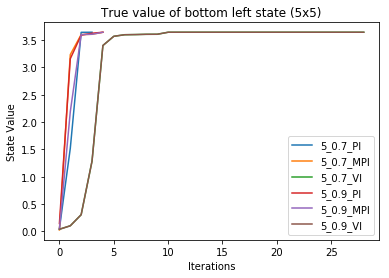

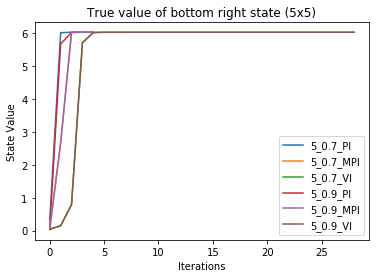

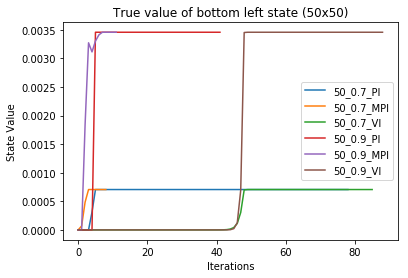

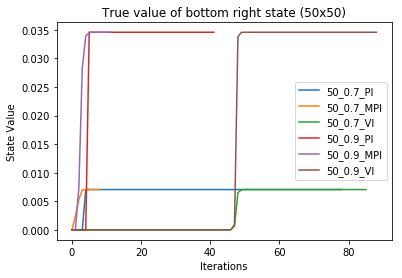

In [35]:
# Plot for bottom left 5
for k, v in stats_bl.items():
    if k.split("_")[0] == "5":
        plt.plot(v, label=k)

plt.legend()
plt.title('True value of bottom left state (5x5)')
plt.xlabel('Iterations')
plt.ylabel('State Value')
plt.show()
plt.close()

# Plot for bottom right 5
for k, v in stats_br.items():
    if k.split("_")[0] == "5":
        plt.plot(v, label=k)

plt.legend()
plt.title('True value of bottom right state (5x5)')
plt.xlabel('Iterations')
plt.ylabel('State Value')
plt.show()
plt.close()

# Plot for bottom left 50
for k, v in stats_bl.items():
    if k.split("_")[0] == "50":
        plt.plot(v, label=k)

plt.legend()
plt.title('True value of bottom left state (50x50)')
plt.xlabel('Iterations')
plt.ylabel('State Value')
plt.show()
plt.close()

# Plot for bottom right 50
for k, v in stats_br.items():
    if k.split("_")[0] == "50":
        plt.plot(v, label=k)

plt.legend()
plt.title('True value of bottom right state (50x50)')
plt.xlabel('Iterations')
plt.ylabel('State Value')
plt.show()
plt.close()

In [37]:
# Policies learned
for k, v in stats_policy.items():
    if k.split("_")[0] == "5":
        print("Policy learned under setting "+k)
        visualize_policy(v, int(k.split("_")[0]))
        print("\n\n")

Policy learned under setting 5_0.7_PI
 →  →  →  →  ↑ 
 →  →  →  →  ↑ 
 →  →  →  ↑  ↑ 
 ↑  →  ↑  ↑  ↑ 
 →  →  →  ↑  ↑ 



Policy learned under setting 5_0.7_MPI
 →  →  →  →  ↑ 
 →  →  →  →  ↑ 
 →  →  →  ↑  ↑ 
 ↑  →  ↑  ↑  ↑ 
 →  →  →  ↑  ↑ 



Policy learned under setting 5_0.7_VI
 →  →  →  →  ↑ 
 →  →  →  →  ↑ 
 →  →  →  ↑  ↑ 
 ↑  →  ↑  ↑  ↑ 
 →  →  →  ↑  ↑ 



Policy learned under setting 5_0.9_PI
 →  →  →  →  ↑ 
 →  →  →  →  ↑ 
 →  →  →  ↑  ↑ 
 ↑  →  ↑  ↑  ↑ 
 →  →  →  ↑  ↑ 



Policy learned under setting 5_0.9_MPI
 →  →  →  →  ↑ 
 →  →  →  →  ↑ 
 →  →  →  ↑  ↑ 
 ↑  →  ↑  ↑  ↑ 
 →  →  →  ↑  ↑ 



Policy learned under setting 5_0.9_VI
 →  →  →  →  ↑ 
 →  →  →  →  ↑ 
 →  →  →  ↑  ↑ 
 ↑  →  ↑  ↑  ↑ 
 →  →  →  ↑  ↑ 





In [58]:
# Policies learned. Have a look at the 50_policies.txt to look at the policies learned
with open("50_policies.txt", "w") as fp:    
    for k, v in stats_policy.items():        
        if k.split("_")[0] == "50":
            fp.write(k+"\n\n")            
            visualize_policy(v, int(k.split("_")[0]), fp)
            fp.write("\n\n")            

## Summary of results

This code demonstrates the use of Dynamic Programming for calculating the state value of the Gridworld MDP. Using, the state value, we can extract out the policy for an agent to behave to in this Gridworld. 

- We demonstrated that all the algorithms converge with a tolerance of 1e-4. Upon convergence, the difference between state values obtained by solving the linear system of equations and iterative evaluation is shown. This difference less than 0.01. Hence we can claim that iterative evaluation of the state values computed using Dynamic Programming provides a good approximation to the true value.
- Modified Policy Iteration requires (MPI) significantly less updates as compared to Policy Iteration (PI) and Value Iteration (VI) in terms of the number of policy updates for convergence for the case of 50x50 Gridworld. Also, the policy evaluation steps required by MPI are less as compared to PI.
- For the case of 5x5, MPI performs comparably with PI in terms of number of policy updates. However, the policy evaluation steps required by PI are significantly more as compared to MPI. VI for 5x5 takes more policy updates steps as compared to both MPI and PI.
- For the case of 5x5, it is interesting to see how the agent learns to avoid the immediate reward, from the cells adjacent to the top left cell, in the quest for a higher future discounted reward by moving towards the top right cell. It must be noted that these policies are based on the value estimates. Hence, these value estimates must somehow encode the knowledge about the environment.
- However, in the 50x50 Gridworld, we are not able to pass the information that it is always better to move towards the top right cell. Looking the policies (./50_policies.txt) we can see that for the cells in top left corner, the agent learns to move towards the top left cell to get a +1 reward as compared to +10 in the top right corner.
- The true values for the bottom right and bottom left states for the 5x5 Gridworld almost converge to the similar values. The only difference is in terms of the number of iterations required to obtain that value.
- We see a similar result in for the 50x50 Gridworld, with one change. The state values converge to similar values, given the probability of randomness in the action. 

### Convergence

While performing the experiments, certain steps must be taken to ensure the convergence, such as:

- Do not reinitialize the state values: Initially, we used to reinitialize the state values whenever we did policy evaluation. However, doing so causes problems in the convergence of Modified Policy Iteration. We might end up in a circular loop in which, we start with some policy, evaluate its value and try to improve the policy based on this evaluation. Since, we are not exactly evaluating the policy we might end up with same policy as what we started with. When we start evaluating the policy next time, with state value estimates zero, we end up with the same value function in the perivious loop, with same policy, getting fixed in a circular loop.

- Round the state values: During experimentation it was noticied that for some cases of PI, the policy was toggling between two actions for a very small number of states (4-5) in the 50x50 Gridworld. To avoid this toggle and making it numerically stable, we round the state values.

### Note

- Please avoid the action suggested in the terminal states by the policy.

## References

1. Reinforcement Learning, An Introduction (Book, Github)
2. https://cs.uwaterloo.ca/~ppoupart/teaching/cs886-spring13/slides/cs886-module7-policy-iteration.pdf?fbclid=IwAR1eoRvzek8g-X-zWhWRT-lihFg13Z7CWTZ37bV4HTtZbRBjzmkL9KQ61s4